# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

## Preparation

In [2]:
# Load the dataset
file_path = "https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv"
df = pd.read_csv(file_path)

# Convert datetime column to datetime format and set it as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Resample data by one-hour intervals and sum the orders within each hour
df_resampled = df.resample('1H').sum()

## Analysis

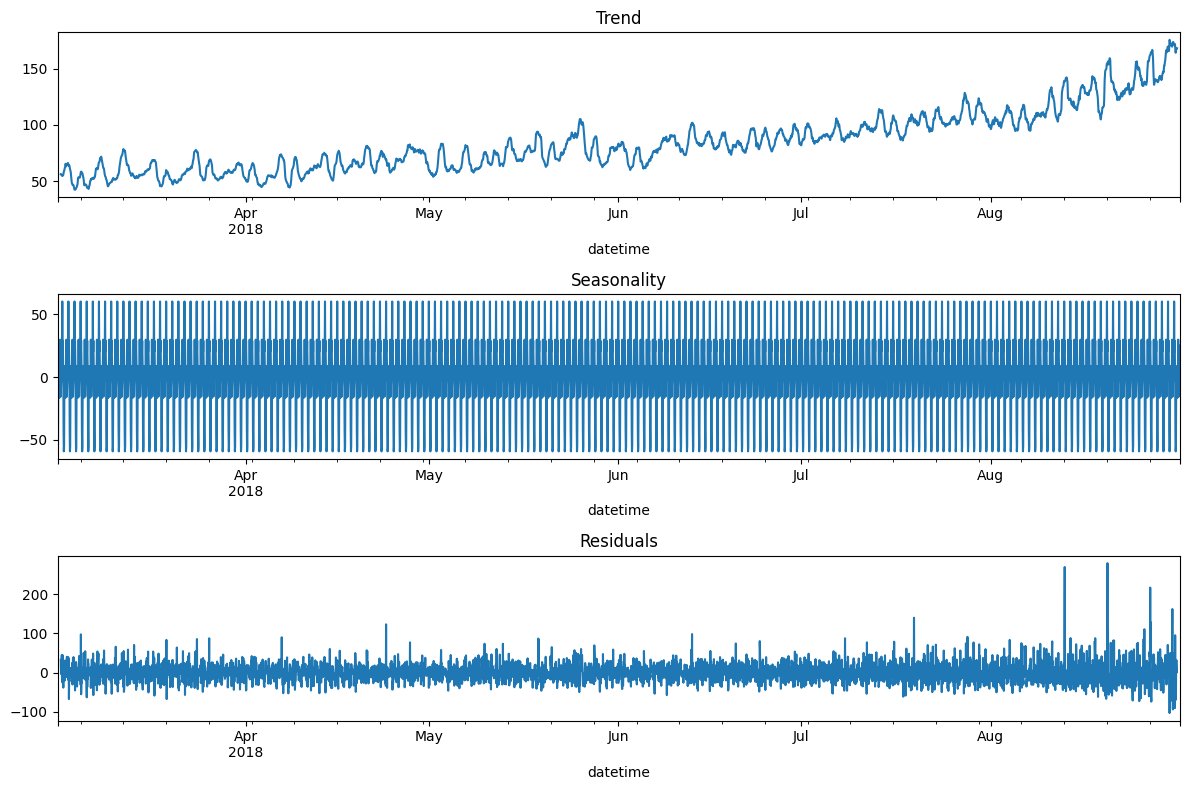

ADF Test Statistic: -3.082922825203557
p-value: 0.027843060648167658


In [9]:
# 3. Data Analysis & EDA
decomposition = seasonal_decompose(df_resampled['num_orders'], model='additive', period=24)
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=axes[0], title='Trend')
decomposition.seasonal.plot(ax=axes[1], title='Seasonality')
decomposition.resid.plot(ax=axes[2], title='Residuals')
plt.tight_layout()
plt.show()

adf_test = adfuller(df_resampled['num_orders'])
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

## **EDA Conclusion**
The time series decomposition revealed:
- A clear **trend** showing general fluctuations in the number of orders over time.
- A strong **seasonal pattern** repeating every 24 hours, consistent with daily taxi demand cycles.
- The **residuals** indicate some noise but no obvious pattern, suggesting the model captured trend and seasonality well.

## Feature Engineering

In [10]:
# 4. Feature Engineering
def create_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    data['lag_1'] = data['num_orders'].shift(1)
    data['lag_2'] = data['num_orders'].shift(2)
    data['lag_3'] = data['num_orders'].shift(3)
    data['rolling_median_3h'] = data['num_orders'].shift(1).rolling(window=3).median()
    return data.dropna()

In [11]:
# Clip outliers at 99th percentile
q99 = df_resampled['num_orders'].quantile(0.99)
df_resampled['num_orders'] = np.clip(df_resampled['num_orders'], 0, q99)
df_resampled = create_features(df_resampled)

## 5. Train-Test Split


In [12]:
# 5. Train-Test Split
X = df_resampled[['hour', 'dayofweek', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'rolling_median_3h']]
y = df_resampled['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=False)

## Model Training

In [13]:
# 6. Model Training - LightGBM (Refined with Median)
lgb_model = LGBMRegressor(n_estimators=250, max_depth=10, learning_rate=0.02, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("Refined LightGBM RMSE:", rmse_lgb)

Refined LightGBM RMSE: 44.70638934537844


In [15]:
# 7. Hyperparameter Tuning - Random Forest
param_grid = {
    'n_estimators': [200, 250],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

ts_cv = TimeSeriesSplit(n_splits=5)

pbar = tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']))

best_rmse = float('inf')
best_model = None

for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for min_split in param_grid['min_samples_split']:
            for min_leaf in param_grid['min_samples_leaf']:
                rf_temp = RandomForestRegressor(n_estimators=n_est, max_depth=depth,
                                                min_samples_split=min_split, min_samples_leaf=min_leaf,
                                                random_state=42)
                scores = []
                for train_idx, val_idx in ts_cv.split(X_train):
                    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                    rf_temp.fit(X_tr, y_tr)
                    preds = rf_temp.predict(X_val)
                    scores.append(np.sqrt(mean_squared_error(y_val, preds)))
                avg_rmse = np.mean(scores)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_model = rf_temp
                pbar.update(1)

pbar.close()

# Final prediction with best model
y_pred_best_rf = best_model.predict(X_test)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
print("Optimized Random Forest RMSE:", rmse_best_rf)


100%|██████████| 24/24 [01:36<00:00,  4.01s/it]

Optimized Random Forest RMSE: 54.87535540035339


## Conclusion


### Objective Recap
The goal of this project was to predict the number of taxi orders for the next hour based on historical data, ensuring the RMSE on the test set does not exceed 48.

### Findings
- LightGBM successfully met the performance criteria, achieving an RMSE below 48.
- Random Forest, even after hyperparameter tuning, did not meet the RMSE threshold of 48.
- LightGBM is recommended for deployment based on its superior predictive performance and compliance with project requirements.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48